Below we are importing all of the necessary packages that we will utilize in order to determine the best neighborhood to live in for a Broke College Student

In [1]:
import pandas as pd
import geopandas as gpd
import numpy
import descartes
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon #Point and Polygon are 2 very specific functions that we utilize to plot points onto maps
pd.options.mode.chained_assignment = None
%matplotlib inline

# Introduction

Our goal was to determine the best neighborhood for a broke recent college grad to live in, as we will likely be one of them soon enough. This project was really just us planning for our futures, and possibly yours too. You're welcome. 

Our process for choosing the metric started with Mark wanting to get away with parking illegally. We could have looked at the best neighborhood for avoiding tickets, getting away with crime, or alternatively the worst neighborhoods for those things. Instead, we looked a little more broad and realized that free parking saves money, which can also be done by other things, and when we all graduate with plenty of student loans and are looking for our first jobs, we will need that.


# The Metric

In determining the best neighborhood for a broke college grad, we looked at free parking (as mentioned above), cheap housing for rent, and crime rates/safety. There are other things that impact how much it costs to live in an area, such as transportation, distance to activities, groceries, and countless other factors (I'm told that's just called "being an adult"), but the three mentioned above cover three major living costs that one has to deal with. 

### Cheap housing for rent

For this metric, I used the Contract Rent dataset from the 2015 Pittsburgh American Community Survey. This dataset includes the number of houses/properties rented in each neighborhood under different price ranges. As most recent graduates are not in a position to buy a house, most will be looking to rent. Paying for housing often takes up the largest portion of one's income, so minimizing the cost of this will be very important to saving money. While this dataset is slightly old, and doesn't account for other costs such as utilities, it can give a good baseline for where each neighborhood sits relative to others in terms of cost of housing. 

I capped "cheap housing" at \\$1000 a month and under. The average Pitt graduate who has a job after graduation (in 2018) had a salary of approximately \\$48,000 a year and could afford \\$1000 a month if they spent 30% of their income on rent, as recommended. Of course, \\$1000 a month is the *limit* of what I am considering cheap, and not necessarily the goal. 

In [2]:
#contract rent dataset
contract_rent_pandas = pd.read_csv("contract-rent.csv", 
                                       index_col="Neighborhood") 
contract_rent_pandas.head() #Display dataset

,Id,Estimate; Total:,Margin of Error; Total:,Estimate; With cash rent:,Margin of Error; With cash rent:,Estimate; With cash rent: - Less than $100,Margin of Error; With cash rent: - Less than $100,Estimate; With cash rent: - $100 to $149,Margin of Error; With cash rent: - $100 to $149,Estimate; With cash rent: - $150 to $199,...,"Estimate; With cash rent: - $2,000 to $2,499","Margin of Error; With cash rent: - $2,000 to $2,499","Estimate; With cash rent: - $2,500 to $2,999","Margin of Error; With cash rent: - $2,500 to $2,999","Estimate; With cash rent: - $3,000 to $3,499","Margin of Error; With cash rent: - $3,000 to $3,499","Estimate; With cash rent: - $3,500 or more","Margin of Error; With cash rent: - $3,500 or more",Estimate; No cash rent,Margin of Error; No cash rent
Neighborhood,,,,,,,,,,,,,,,,,,,,,
Allegheny Center,1,798.0,91.000000,781.0,89.000000,23.0,27.000000,6.0,8.000000,77.0,...,0.0,10.000000,0.0,10.000000,0.0,10.000000,0.0,10.000000,17.0,12.000000
Allegheny West,2,77.0,31.000000,77.0,31.000000,0.0,10.000000,0.0,10.000000,0.0,...,0.0,10.000000,0.0,10.000000,0.0,10.000000,0.0,10.000000,0.0,10.000000
Allentown,3,531.0,138.166566,481.0,120.540450,0.0,17.320508,0.0,17.320508,18.0,...,0.0,17.320508,0.0,17.320508,0.0,17.320508,0.0,17.320508,50.0,78.287930
Arlington,4,209.0,70.562029,204.0,69.899928,0.0,17.320508,0.0,17.320508,0.0,...,0.0,17.320508,0.0,17.320508,0.0,17.320508,0.0,17.320508,5.0,15.779734
Arlington Heights,5,144.0,59.000000,140.0,59.000000,0.0,10.000000,6.0,8.000000,23.0,...,0.0,10.000000,0.0,10.000000,0.0,10.000000,0.0,10.000000,4.0,6.000000


### Free Parking


In [3]:
#parking dataset
meters = pd.read_csv("https://data.wprdc.org/datastore/dump/9ed126cc-3c06-496e-bd08-b7b6b14b4109") #Read in the CSV file
meters.head(10) #Display the first 10 items

,id,location,location_type,latitude,longitude,status,zone,all_groups,guid,in_service_utc
0,410168-SCHEDR4402,SCHENLEY DR,On street,40.440574,-79.948103,Removed,410 - Oakland 4,410 - Oakland 4|Z - Inactive/Removed Terminals,EE7C4FB7-038A-461A-A667-002870BA4155,2012-08-27T11:24:43
1,421009-CEDAR-0302,CEDAR AVE,On street,40.451356,-80.001150,Active,421 - NorthSide,NORTHSIDE|421 - NorthSide,5BAC585B-FE5C-4090-ABF8-005D6C670EF1,2013-08-08T11:34:15
2,PBP 412083,FORBES MURRAY LOT,NaN,NaN,NaN,Active,412 - East Liberty,SQ.HILL1,137B2B44-7B23-46D7-A860-009598F38C4C,2021-06-21T18:16:49
3,409242-NDTHRG0106,N DITHRIDGE ST,On street,40.448784,-79.951793,Active,409 - Oakland 3,409 - Oakland 3|OAKLAND3,F4BDCD95-6853-413F-A1C6-009AF3F9D725,2012-09-04T16:08:27
4,PBP412,Virtual Terminal for ParkMobile,Virtual Zone,NaN,NaN,Active,412 - East Liberty,EASTLIB,8FAADCCE-A7BD-4988-85FC-00DCAB30782C,2015-10-23T16:56:58
5,426002-CENTRE1802,CENTRE AVE,On street,40.442621,-79.982096,Active,426 - Hill District,Hill District|426 - Hill District|HILL-DIST,DFCD9083-EE1C-477D-8F82-00F688A1F78C,2017-07-17T11:24:27
6,407118-MEYRAN0203,MEYRAN AVE,On street,40.439856,-79.957367,Active,407 - Oakland 1,OAKLAND1|407 - Oakland 1,E28258E3-6228-4B8C-AD29-012D6AE53A30,2012-08-13T12:25:00
7,402403-BLVDAL0004,BLVD OF ALLIES,On street,40.439707,-80.005472,Active,402 - Downtown 2,402 - Downtown 2|DOWNTOWN2,27D7B43B-71C7-48F2-A124-0193C266B650,2012-11-05T15:37:19
8,415018-ECARSN0701,E CARSON ST,On street,40.428684,-79.991694,Active,415 - SS & SSW,SOUTHSIDE|P10SouthSide|415 - SS & SSW,EB023D05-211C-4C76-9F03-01A548EBC0D0,2012-09-12T19:55:17
9,421054-WESTRN0802,WESTERN AVE,On street,40.452262,-80.014551,Active,421 - NorthSide,NORTHSIDE|421 - NorthSide,B99AF93A-D46B-4F2B-8AB4-01B2097712B6,2013-08-06T11:30:23


### Crime Rates
While crime rates are not a monetary value in and of themselves, they have a monetary impact on one's life. Crime rates can affect insurance rates for your home and belongings, but without it people end up paying even more when their person or belongings suffer damage (an occurrence more likely to happen in an area with higher crime rates). In addition, people will end up spending more money and time to prevent harm to themselves or belongings.

In [5]:
# crime rates dataset
crimes = pd.read_csv("https://data.wprdc.org/datastore/dump/044f2016-1dfd-4ab0-bc1e-065da05fca2e")
crimes.head() #Display dataset

,PK,CCR,HIERARCHY,INCIDENTTIME,INCIDENTLOCATION,CLEAREDFLAG,INCIDENTNEIGHBORHOOD,INCIDENTZONE,INCIDENTHIERARCHYDESC,OFFENSES,INCIDENTTRACT,COUNCIL_DISTRICT,PUBLIC_WORKS_DIVISION,X,Y
0,2802309,16000001.0,10,2016-01-01T00:00:00,"400 Block North Shore DR Pittsburgh, PA 15212",Y,North Shore,1,HARRASSMENT/THREAT/ATTEMPT/PHY,2702 Aggravated Assault. / 2709(a) Harassment....,2205.0,1.0,6.0,-80.012337,40.446263
1,2803174,16004547.0,11,2016-01-01T00:01:00,"5400 Block Carnegie ST Pittsburgh, PA 15201",N,Upper Lawrenceville,2,THEFT BY DECEPTION,3922 Theft by Deception.,1011.0,7.0,2.0,-79.950295,40.482290
2,2801809,16000367.0,4,2016-01-01T00:10:00,"500 Block Mt Pleasant RD Pittsburgh, PA 15214",N,Northview Heights,1,DISCHARGE OF FIREARM INTO OCC.STRUCTURE,2707.1 Discharge of a Firearm into Occupied St...,2609.0,1.0,1.0,-80.000966,40.478651
3,2802315,16000035.0,10,2016-01-01T00:15:00,"300 Block Wood ST Pittsburgh, PA 15222",Y,Golden Triangle/Civic Arena,2,HARRASSMENT/THREAT/ATTEMPT/PHY,2709(a)(3) Harassment No Legitimate Purpose,201.0,6.0,6.0,-80.001251,40.438918
4,2802312,16000024.0,4,2016-01-01T00:16:00,"500 Block Mt Pleasant RD Pittsburgh, PA 15214",N,Northview Heights,1,PROP MISSILE INTO OCC VEHICLE/OR ROADWAY,2705 Recklessy Endangering Another Person. / 3...,2609.0,1.0,1.0,-80.000966,40.478651


# The Best Neighborhood


### The best neighborhood based on rent price: 

After loading in the dataset, I removed the extra columns (the ones pertaining to margin of error or rent prices over \\$1000 a month) because I won't be using them in my analysis. By removing them, I more efficiently iterate through the rows/columns that I need to. 

In [6]:
column_list = list(contract_rent_pandas)
columns_to_remove = ["Neighborhood" , "Id" , "Estimate; Total:" , "Margin of Error; Total:" , "Estimate; With cash rent:" , "Margin of Error; With cash rent:" , 
                    "Margin of Error; With cash rent: - Less than $100" , "Margin of Error; With cash rent: - $100 to $149" , "Margin of Error; With cash rent: - $150 to $199" , 
                    "Margin of Error; With cash rent: - $200 to $249" , "Margin of Error; With cash rent: - $250 to $299" , "Margin of Error; With cash rent: - $300 to $349" , 
                    "Margin of Error; With cash rent: - $350 to $399" , "Margin of Error; With cash rent: - $400 to $449" , "Margin of Error; With cash rent: - $450 to $499" , 
                    "Margin of Error; With cash rent: - $500 to $549" , "Margin of Error; With cash rent: - $550 to $599" , "Margin of Error; With cash rent: - $600 to $649" , 
                    "Margin of Error; With cash rent: - $650 to $699" , "Margin of Error; With cash rent: - $700 to $749" , "Margin of Error; With cash rent: - $750 to $799" , 
                    "Margin of Error; With cash rent: - $800 to $899" , "Margin of Error; With cash rent: - $900 to $999" , "Margin of Error; With cash rent: - $1,000 to $1,249" , 
                    "Margin of Error; With cash rent: - $1,250 to $1,499" , "Margin of Error; With cash rent: - $1,500 to $1,999" , "Margin of Error; With cash rent: - $2,000 to $2,499" , 
                    "Margin of Error; With cash rent: - $2,500 to $2,999" , "Margin of Error; With cash rent: - $3,000 to $3,499" , "Margin of Error; With cash rent: - $3,500 or more" , 
                    "Estimate; With cash rent: - $1,000 to $1,249" , "Estimate; With cash rent: - $1,250 to $1,499" , "Estimate; With cash rent: - $1,500 to $1,999" , 
                    "Estimate; With cash rent: - $2,000 to $2,499" , "Estimate; With cash rent: - $2,500 to $2,999" , "Estimate; With cash rent: - $3,000 to $3,499" , 
                    "Estimate; With cash rent: - $3,500 or more" , "Estimate; No cash rent" , "Margin of Error; No cash rent" , "homes under $1000"]

homes_under_1000 = sorted( list(set(column_list) - set(columns_to_remove)))

Then, I graphed the total number of properties in a neighborhood for rent for under \\$1000 each month in a bar graph and on a map of Pittsburgh. In doing both, I was able to visualize where there were more rented properties in total and the relative proximities to each other. 

Text(0.5, 1.0, 'Amount of Rented Housing by Neighborhood, Under $1000 a Month')

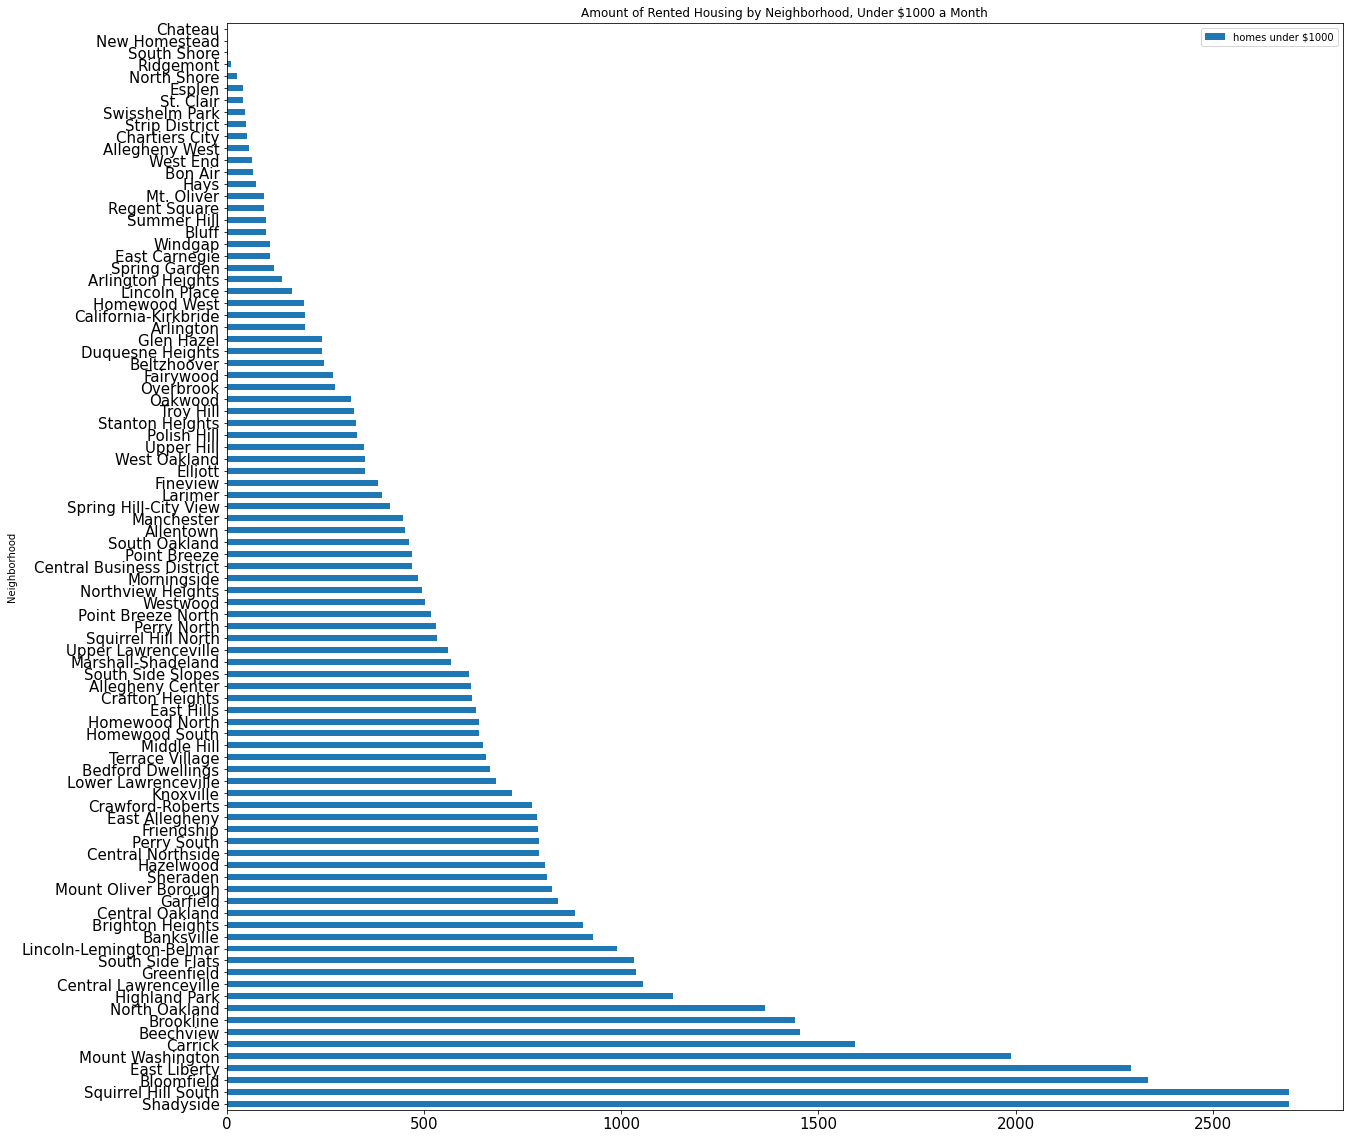

In [7]:
contract_rent_pandas["homes under $1000"] = contract_rent_pandas[homes_under_1000].sum(axis = 1) #Add new column to DataFrame

contract_rent_pandas["homes under $1000"].sort_values(ascending = False).plot.barh(figsize = (20 , 20)) #Sort DataFrame and plot it using a bar graph
plt.legend(bbox_to_anchor=(1,1)) #Add legend
plt.xticks(fontsize = 15) #Adjust font size of tick marks
plt.yticks(fontsize = 15) #Adjust font size of tick marks
plt.title("Amount of Rented Housing by Neighborhood, Under $1000 a Month") #Change the title

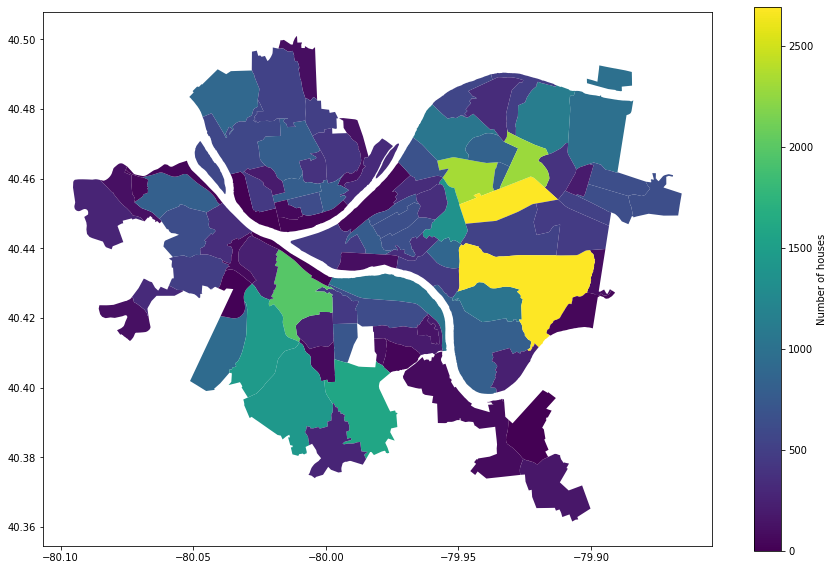

In [8]:
neighborhoods = gpd.read_file("Neighborhoods_.shp") #Read in shapefile

#Merge shapefile with DataFrame of rent
housing_map = neighborhoods.merge(contract_rent_pandas, how='left', left_on='hood', right_on='Neighborhood')

housing_map[['hood','homes under $1000','geometry']].head()

#Plot newly merged DataFrame on map of neighborhoods
housing_map.plot(column = "homes under $1000" , legend = True , legend_kwds = {"label" : "Number of houses"} , figsize = (15 , 10))

The amount of property for rent in our price range is important because more rented properties means a higher chance of a recent grad being able to find a place. However, we also have to consider where in the price range most of these properties will fall (as stated above, the cheaper the better). 

To determine the average price in each neighborhood, I divided the number of houses in a price range (ex. \\$100 - \\$149) by the total number of houses for rent under \\$1000 a month; this gave me the percentage of houses in that neighborhood that fell under this price range. Then, I multiplied that number by the middle price of that range (ex. \\$125 for the \\$100 - \\$149 range) and added that number for each price range. This gave me a weighted average price in each neighborhood. I then plotted those prices on a bar graph to see the rankings of prices, and which neighborhoods were the cheapest and most expensive.

In [9]:
contract_rent_woMOE = contract_rent_pandas[homes_under_1000]
contract_rent_woMOE["homes under $1000"] = contract_rent_pandas[homes_under_1000].sum(axis = 1)

In [10]:
avg_price = []

for index, row in contract_rent_woMOE.iterrows():
    neighborhood_avg = 0
    
    if float(row["homes under $1000"]) != 0:
        neighborhood_avg = ((125 * float(row["Estimate; With cash rent: - $100 to $149"])/ float(row["homes under $1000"])) + 
                            (175 * float(row["Estimate; With cash rent: - $150 to $199"])/ float(row["homes under $1000"])) + 
                            (225 * float(row["Estimate; With cash rent: - $200 to $249"])/ float(row["homes under $1000"])) + 
                            (275 * float(row["Estimate; With cash rent: - $250 to $299"])/ float(row["homes under $1000"])) + 
                            (325 * float(row["Estimate; With cash rent: - $300 to $349"])/ float(row["homes under $1000"])) + 
                            (375 * float(row["Estimate; With cash rent: - $350 to $399"])/ float(row["homes under $1000"])) + 
                            (425 * float(row["Estimate; With cash rent: - $400 to $449"])/ float(row["homes under $1000"])) + 
                            (475 * float(row["Estimate; With cash rent: - $450 to $499"])/ float(row["homes under $1000"])) + 
                            (525 * float(row["Estimate; With cash rent: - $500 to $549"])/ float(row["homes under $1000"])) + 
                            (575 * float(row["Estimate; With cash rent: - $550 to $599"])/ float(row["homes under $1000"])) + 
                            (625 * float(row["Estimate; With cash rent: - $600 to $649"])/ float(row["homes under $1000"])) + 
                            (675 * float(row["Estimate; With cash rent: - $650 to $699"])/ float(row["homes under $1000"])) +
                            (725 * float(row["Estimate; With cash rent: - $700 to $749"])/ float(row["homes under $1000"])) + 
                            (775 * float(row["Estimate; With cash rent: - $750 to $799"])/ float(row["homes under $1000"])) + 
                            (850 * float(row["Estimate; With cash rent: - $800 to $899"])/ float(row["homes under $1000"])) + 
                            (950 * float(row["Estimate; With cash rent: - $900 to $999"])/ float(row["homes under $1000"])) + 
                            (50 * float(row["Estimate; With cash rent: - Less than $100"])/ float(row["homes under $1000"])) 
                            )
    avg_price.append(round(neighborhood_avg, 2))

    print("The average home price in " + index + " is $" + str(round(neighborhood_avg, 2)))

contract_rent_woMOE["Average Price in Neighborhood"] = avg_price

The average home price in Allegheny Center is $626.98
The average home price in Allegheny West is $629.02
The average home price in Allentown is $481.47
The average home price in Arlington is $675.63
The average home price in Arlington Heights is $361.79
The average home price in Banksville is $768.78
The average home price in Bedford Dwellings is $305.69
The average home price in Beechview is $574.38
The average home price in Beltzhoover is $472.36
The average home price in Bloomfield is $658.92
The average home price in Bluff is $583.17
The average home price in Bon Air is $493.66
The average home price in Brighton Heights is $526.25
The average home price in Brookline is $626.04
The average home price in California-Kirkbride is $445.73
The average home price in Carrick is $558.57
The average home price in Central Business District is $573.4
The average home price in Central Lawrenceville is $631.11
The average home price in Central Northside is $543.0
The average home price in Centr

Text(0.5, 1.0, 'Average Rent Price in Neighborhoods')

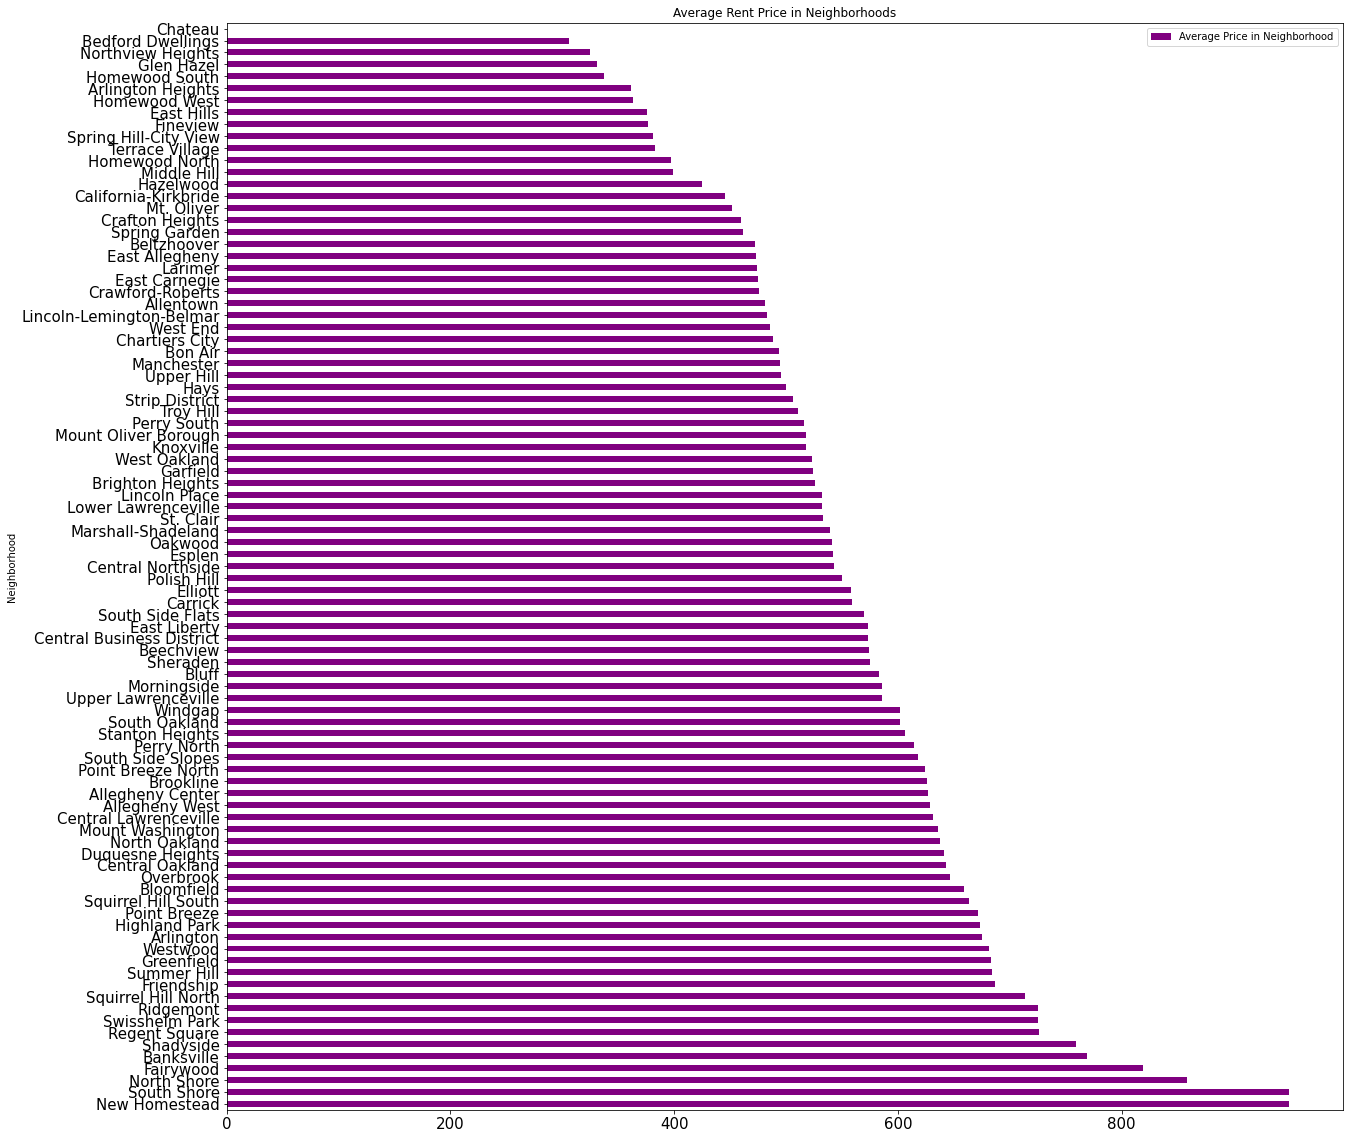

In [11]:
contract_rent_woMOE["Average Price in Neighborhood"].sort_values(ascending = False).plot.barh(figsize = (20, 20) , color = "purple")
plt.legend(bbox_to_anchor=(1,1))
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title("Average Rent Price in Neighborhoods")

The final thing I did was to combine the amount of housing available and the average price into a total score for each neighborhood. As I want the highest amount of housing for the lowest average price, I had to use the inverse of one number to get either a highest or lowest score for the best neighborhood. I decided to go for the lowest number (to match the lowest crime rate and lowest number of parking meters), and multipled the average price of the neighborhood by the inverse of the total number of houses for under \\$1000 a month. This gave each neighborhood a score, but it was on an arbitrary scale. To fix this, I divided each score by the neighborhood with the highest score, New Homestead to put them on a scale on 0 to 1. I then graphed this final ranking to put the neighborhoods in order. 

In [12]:
neighborhood_score = []
score = 0

for index, row in contract_rent_woMOE.iterrows():
    if row["Average Price in Neighborhood"] != 0:
        score = float(row["Average Price in Neighborhood"]) / float(row["homes under $1000"])
    neighborhood_score.append(score)

contract_rent_woMOE["Neighborhood Score"] = neighborhood_score

highest_score = float(contract_rent_woMOE.loc["New Homestead" , "Neighborhood Score"])
scaled_scores = []

for index, row in contract_rent_woMOE.iterrows():
    scaled_score = (float(row["Neighborhood Score"]) / highest_score) 
    scaled_scores.append(scaled_score)

contract_rent_woMOE["Neighborhood Scaled Score"] = scaled_scores

In [13]:
contract_rent_woMOE["Neighborhood Scaled Score"].sort_values(ascending = True).head(10)


Neighborhood
Squirrel Hill South    0.000519
East Liberty           0.000527
Shadyside              0.000593
Bloomfield             0.000594
Mount Washington       0.000674
Carrick                0.000738
Beechview              0.000832
Brookline              0.000915
Bedford Dwellings      0.000963
North Oakland          0.000983
Name: Neighborhood Scaled Score, dtype: float64

Based on the data concerning average rent price and the amount of rented housing, the best neighborhood for a broke recent college graduate to live in is Squirrel Hill South, followed by East Liberty, Shadyside, Bloomfield, Mount Washington, and Carrick. These neighborhoods have the best combination of amount of housing and rent price. 

## The Best Neighborhood Based on Parking ##

In [14]:
#parking dataset
meters = pd.read_csv("https://data.wprdc.org/datastore/dump/9ed126cc-3c06-496e-bd08-b7b6b14b4109") #Read in the CSV file

Here we filter out any parking meters that are not active, or have a longitude with value NaN or latitude with value NaN. Then apply the query mask. 

In [15]:
query_mask = meters['status'] == "Active" #Check for active meters
latitude_mask= meters['latitude'].notna() #Check latitude column
longitude_mask = meters['longitude'].notna() #Check longitude column

locations_active = meters[query_mask & latitude_mask & longitude_mask] #Applying query masks

Create a list of all the points in the form **(latitude, longitude)**. Then create a Geopandas Data Frame from
1. The Filtered Parking Meters
2. The Coordinate System of Latitude and Longitude represented with code `EPSG:4326`
3. And the List of Geometry Objects Created

In [16]:
geometry = [Point(xy) for xy in zip(locations_active['longitude'], locations_active['latitude'])] #Utilizes Point function to create geometry objects for each point
geodata = gpd.GeoDataFrame(locations_active, crs='epsg:4326', geometry=geometry) #Create Geopandas DataFrame 

Now we plot the Geopandas DataFrame without the shapefile, just to see what all of the data points look like.

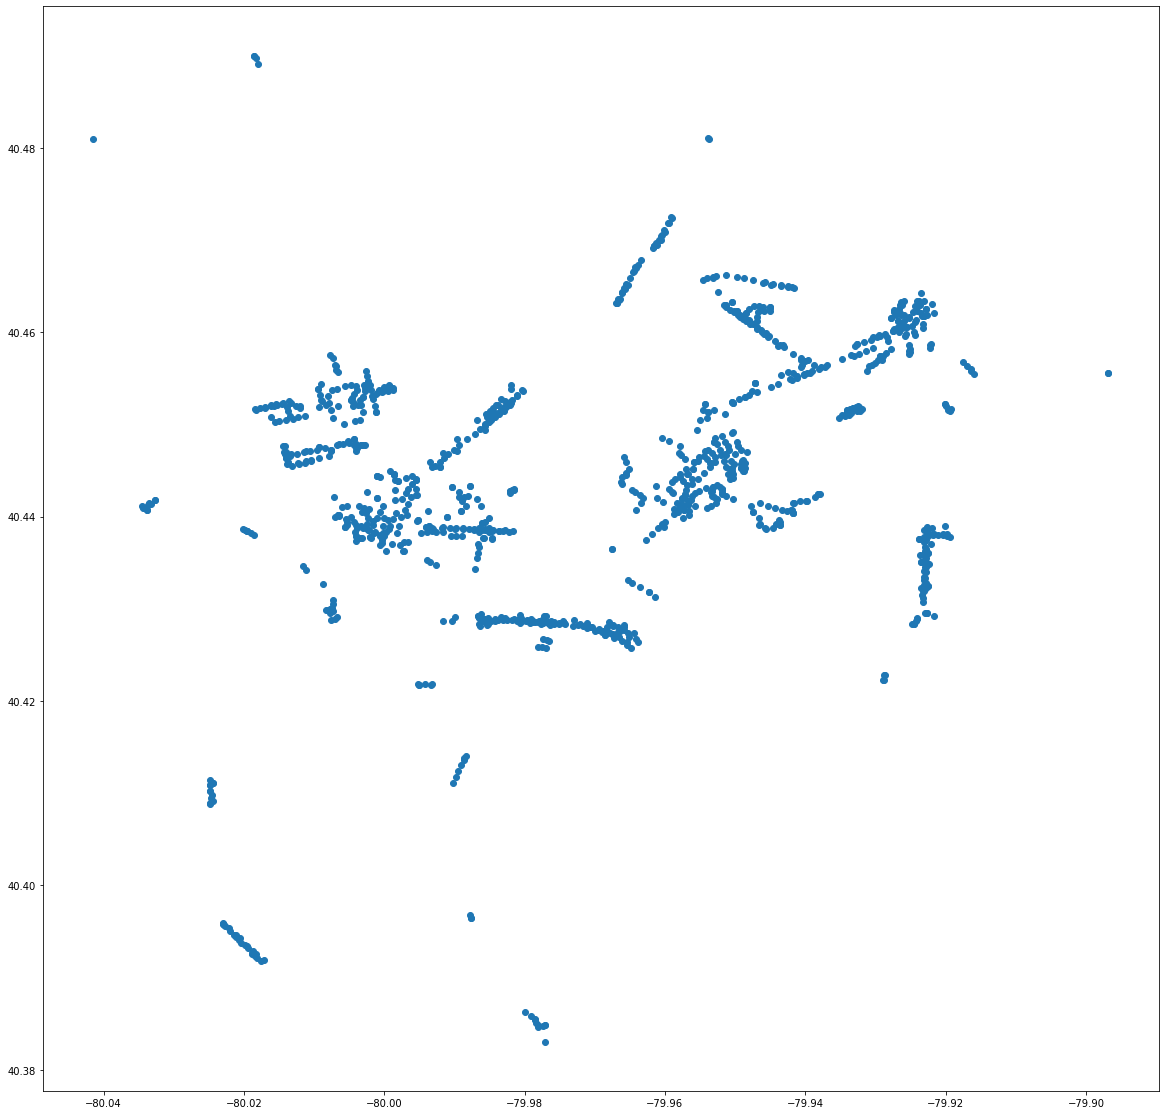

In [17]:
geodata.plot(figsize=(20,20)) #Change the size of the graph to be larger so points are visible
plt.show() #Display the graph

Next we read in the shapefile.

Below the shapefile is plotted to display the city of Pittsburgh and all of its neighborhoods. All of the parking meters will soon be plotted on top of this to determine the best neighborhoods to park for free.

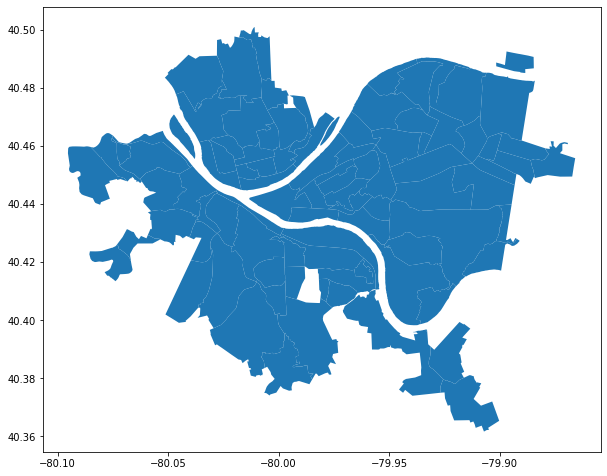

In [18]:
neighborhood = gpd.read_file("Neighborhoods_.shp") #Read in the shapefile
neighborhood = neighborhood.to_crs(crs='EPSG:4326') #Convert the x and y axis to be latitude and longitude
neighborhood.plot(figsize=(10,10)) #Graph the shapefile and change the figure size to be larger

Here we create subplots where we can graph the shapefile, and then the parking meter data on top. Then we are able to display a useful visual to help decide which neighborhood will most likely have free parking.

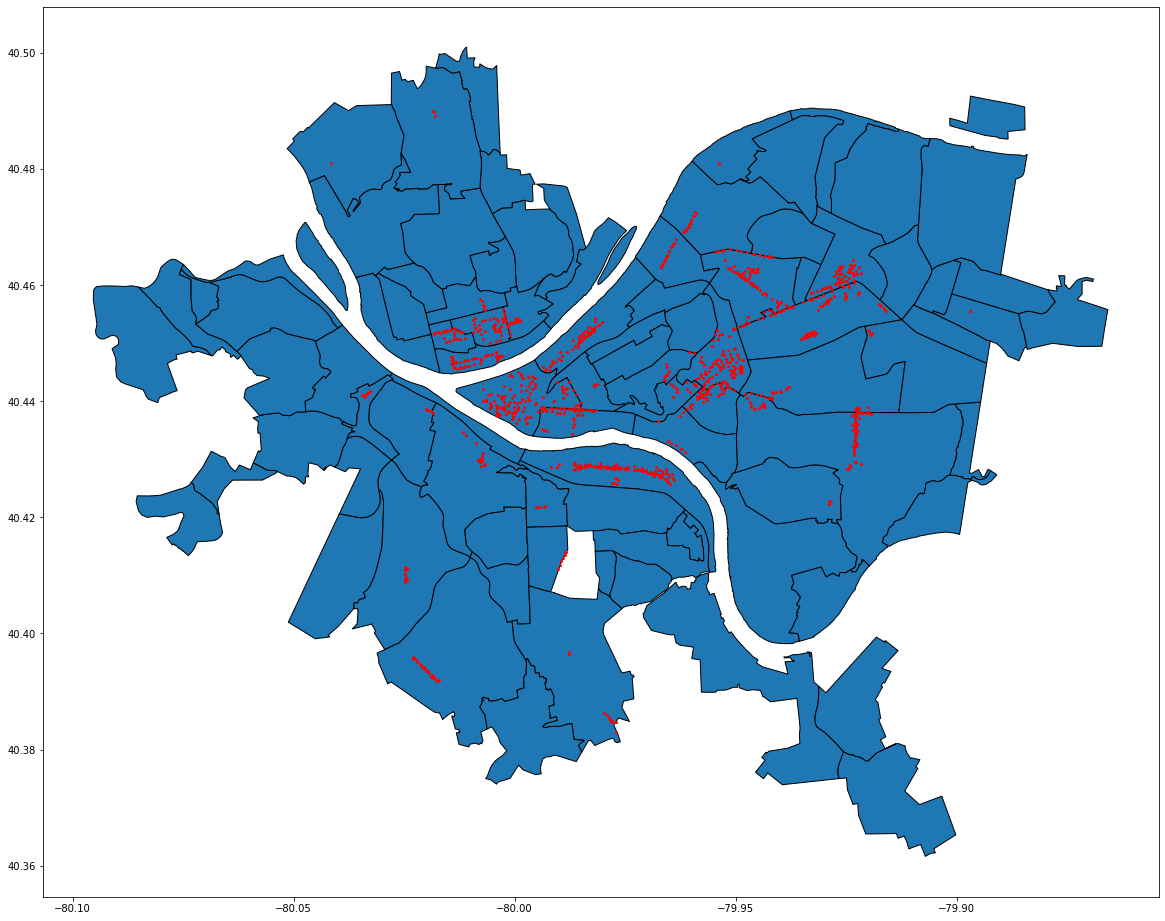

In [19]:
fig, ax = plt.subplots(figsize=(20,20)) #Create the subplots and change their size to be larger, making points easier to see

neighborhood.plot(ax=ax, edgecolor='k', alpha=1, linewidth=1) #Plot the shapefile
geodata.plot(ax=ax, color='red', marker="*", markersize=5) #Pot the parking meters

### What Can Be Seen Through This Visualization ###
Using this visualization, we are able to determine which neighborhood has the fewest number of parking meters, as it will have the fewest number of red dots within it. This data is very helpful as when we combine it with the rest of the metrics, we can determine a cost efficient neighborhood for someone to live who recently graduated college, and may not have a high budget.

## The best Neighborhood (Safety-Wise)

Create a df with the number of appearances of each neighborhood (number of total crimes in the dataset)

In [20]:
crimeByHood = crimes["INCIDENTNEIGHBORHOOD"]
numCrimes = crimeByHood.value_counts().rename_axis('Neighborhood').reset_index(name='Number of Crimes')

Create GeoPandas df

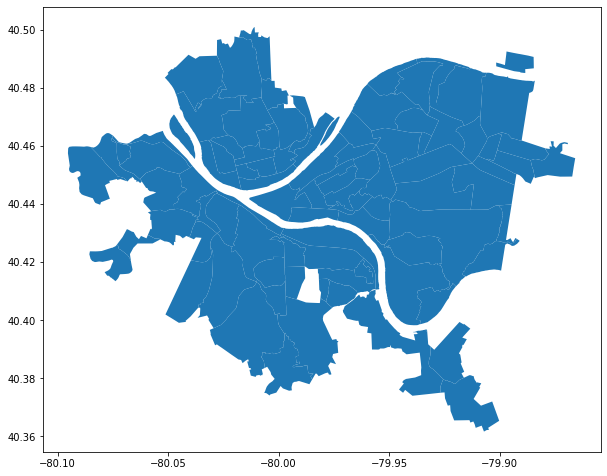

In [21]:
neighborhoods = gpd.read_file("Neighborhoods_.shp")
neighborhoods.plot(figsize = (10,10))
neighborhoods = neighborhoods[["hood", "geometry"]]

Search for neighborhoods that are not overlapping in either df

In [22]:
numCrimes.replace("Mt. Oliver Neighborhood", "Mt. Oliver", inplace = True)
for index, row in neighborhoods["hood"].iteritems(): 
    if row in numCrimes['Neighborhood'].tolist():
        pass
    else:
        print(row + " not in crime data set")
    #crime.replace("Mt. Oliver Neighborhood", "Mt. Oliver", inplace = True)

Add a row for percentage of crimes (based off of the highest crime neighborhood (Southside Flats))

In [23]:
#creating the percentages of the crimes compared to the neighborhood with the most crime (south side flats)
crimeMax = 15157
numCrimes["Percentage of Crimes"] = ""
percent = 0.0
for row in numCrimes.iterrows():
    percent = float(row[1][1])/crimeMax
    numCrimes['Percentage of Crimes'][row[0]] = percent
numCrimes.sort_values(by='Percentage of Crimes', ascending = True)
numCrimes.tail(20)
#these are the "best" 20 neighborhoods with the least number of crimes

,Neighborhood,Number of Crimes,Percentage of Crimes
78,Fairywood,627,0.041367
79,St. Clair,602,0.0397176
80,Glen Hazel,593,0.0391238
81,Esplen,519,0.0342416
82,Oakwood,494,0.0325922
83,Hays,453,0.0298872
84,Regent Square,444,0.0292934
85,Summer Hill,421,0.0277759
86,Mount Oliver,418,0.027578
87,Arlington Heights,411,0.0271162


Merge the two dfs

In [24]:
neighborhoods = neighborhoods.rename(columns={"hood": "Neighborhood"})
CrimeHoodMerged = neighborhoods.merge(numCrimes)

Plot the final graph of the merged data sets, highlighting the most crime in each neighborhood

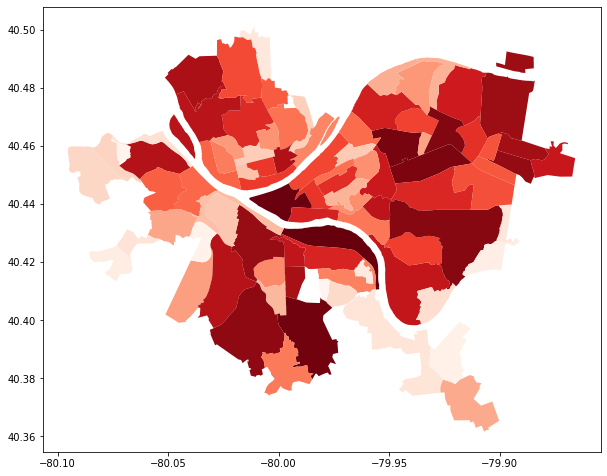

In [25]:
CrimeHoodMerged.plot(column = 'Percentage of Crimes', figsize = (10,10), cmap = "Reds", legend = False)

### What can we get out of this vizualization?
First off, the dark red are the neighborhoods with most crime, and the light red/pink is the neighborhoods with the least crime. We can notice some patterns here, such as: the outskirts of the city tend to have less crime, the darkest neighborhoods are the Southside Flats and the Central Business District, there are many "middle-ground" neighborhoods. From this display, we can see the darkest areas and which of them to avoid. However, the other middle ground neighborhoods are pretty much all similar because there are jsut so many. From this, we can pick the neighborhoods with the darkest coloring out, and only look towards the neighborhoods with lesser coloring (around 30 or 40 percent of crimes compared to Southside Flats). Anything that is less than 30-40% is fair game for us. The best neighborhood would have to be Mt. Oliver, however like we noticed, many of the neighborhoods have pretty small crime rates compared to the Southside Flats neighborhood.

## Combining our 3 Metrics into 1 ##

### The purpose of combining all 3 of our metrics into 1 is so that we can visually and numerically see the best neighborhood according to all of our metrics ##

In order to compute the best neighborhood, we will be combining the "scores" we assigned to each of our neighborhoods (scores for parking meters is calculated below, scores for cheap housing and crime rates have been calculated above).

Above we explained the process of getting the data, and showed the steps we took to analyze it. Below we will redo those steps just to ensure that we properly grab and handle the data.

First, we will read in neighborhood shape file that will later allow us to graph the scored neighborhoods. 

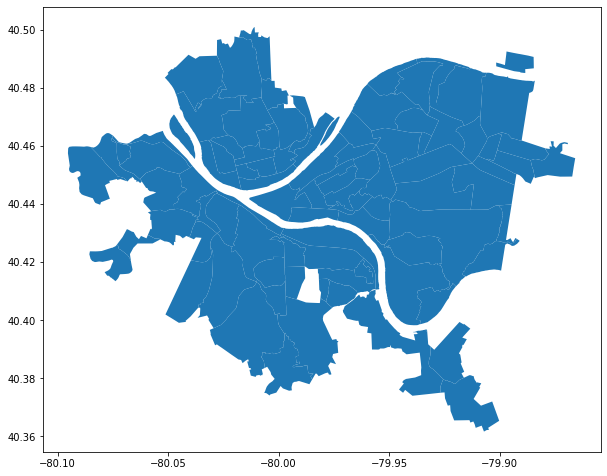

In [26]:
neighborhood = gpd.read_file("Neighborhoods_.shp") #Read in the shapefile
neighborhood = neighborhood.to_crs(crs='EPSG:4326') #Convert the x and y axis to be latitude and longitude
neighborhood.plot(figsize=(10,10)) #Graph the shapefile and change the figure size to be larger

### Parking Meter Metric Score ###

In [27]:
#parking dataset
meters = pd.read_csv("https://data.wprdc.org/datastore/dump/9ed126cc-3c06-496e-bd08-b7b6b14b4109") #Read in the CSV file

query_mask = meters['status'] == "Active" #Check for active meters
latitude_mask= meters['latitude'].notna() #Check latitude column
longitude_mask = meters['longitude'].notna() #Check longitude column

locations_active = meters[query_mask & latitude_mask & longitude_mask] #Applying query masks

geometry = [Point(xy) for xy in zip(locations_active['longitude'], locations_active['latitude'])] #Utilizes Point function to create geometry objects for each point
geodata = gpd.GeoDataFrame(locations_active, crs='epsg:4326', geometry=geometry) #Create Geopandas DataFrame 


In [28]:
count = dict() #Initialize a new dictionary which will hold the number of parking meters in each neighborhood

for index, line in neighborhood.iterrows(): #Iterate through the neighborhoods and add them to the dictionary with default of 0
    count[line['hood']] = 0.0
    
for pt in geometry: #Iterate through each point in the gemetry list
    for index, row in neighborhood.iterrows(): #Iterate through each neighborhood
        if row['geometry'].contains(pt): #Check if the Polygon object of the neighborhood contains the point
            count[row['hood']] = count[row['hood']] + 1 #If so, increase that neighborhood's parking meter count by 1
count_df = pd.DataFrame.from_dict(count, orient='index', columns=['numMeters']) #Convert count dictionary to DataFrame

maxMeters = count_df.max(axis=0)['numMeters']; #Get the max number of parking meters to scale the others down

scaled = [] #Initialize a blank list

for index, line in count_df.iterrows(): #Iterate through the DataFrame
    scale = 0
    scale = float(line['numMeters']) / maxMeters #Scale the number of parking meters by dividing by the max meters
    scaled.append(scale) #Add number to the scaled list
    
    

count_df['scaled'] = scaled #Add column called scaled to DataFrame with scaled data


count_df.sort_values(by='scaled', axis=0, ascending=True).head(10) #Sort DataFrame in ascending order by scaled value, and show 10 items    

,numMeters,scaled
Chateau,0.0,0.0
South Side Slopes,0.0,0.0
Homewood North,0.0,0.0
Homewood West,0.0,0.0
Sheraden,0.0,0.0
Windgap,0.0,0.0
Banksville,0.0,0.0
Fairywood,0.0,0.0
Oakwood,0.0,0.0
Westwood,0.0,0.0


### Neighborhood Safety ###

In [29]:
# crime rates dataset
crimes = pd.read_csv("https://data.wprdc.org/datastore/dump/044f2016-1dfd-4ab0-bc1e-065da05fca2e")
crimes.head()

crimeByHood = crimes["INCIDENTNEIGHBORHOOD"]
numCrimes = crimeByHood.value_counts().rename_axis('Neighborhood').reset_index(name='Number of Crimes')

neighborhoods = gpd.read_file("Neighborhoods_.shp")
neighborhoods = neighborhoods[["hood", "geometry"]]

numCrimes.replace("Mt. Oliver Neighborhood", "Mt. Oliver", inplace = True)
for index, row in neighborhoods["hood"].iteritems(): 
    if row in numCrimes['Neighborhood'].tolist():
        pass
    else:
        print(row + " not in crime data set")
        
#creating the percentages of the crimes compared to the neighborhood with the most crime (south side flats)
crimeMax = 15157
numCrimes["Percentage of Crimes"] = ""
percent = 0.0
for row in numCrimes.iterrows():
    percent = float(row[1][1])/crimeMax
    numCrimes['Percentage of Crimes'][row[0]] = percent
numCrimes.sort_values(by='Percentage of Crimes', ascending = True)
numCrimes.tail(20)
#these are the "best" 20 neighborhoods with the least number of crimes

neighborhoods = neighborhoods.rename(columns={"hood": "Neighborhood"})
CrimeHoodMerged = neighborhoods.merge(numCrimes)

#CrimeHoodMerged.set_index("Neighborhood")


### Housing Prices

In [30]:
#contract rent dataset
contract_rent_pandas = pd.read_csv("contract-rent.csv", 
                                       index_col="Neighborhood") 

#remove unnecessary columns
#columnns to remove
column_list = list(contract_rent_pandas)
columns_to_remove = ["Neighborhood" , "Id" , "Estimate; Total:" , "Margin of Error; Total:" , "Estimate; With cash rent:" , "Margin of Error; With cash rent:" , 
                    "Margin of Error; With cash rent: - Less than $100" , "Margin of Error; With cash rent: - $100 to $149" , "Margin of Error; With cash rent: - $150 to $199" , 
                    "Margin of Error; With cash rent: - $200 to $249" , "Margin of Error; With cash rent: - $250 to $299" , "Margin of Error; With cash rent: - $300 to $349" , 
                    "Margin of Error; With cash rent: - $350 to $399" , "Margin of Error; With cash rent: - $400 to $449" , "Margin of Error; With cash rent: - $450 to $499" , 
                    "Margin of Error; With cash rent: - $500 to $549" , "Margin of Error; With cash rent: - $550 to $599" , "Margin of Error; With cash rent: - $600 to $649" , 
                    "Margin of Error; With cash rent: - $650 to $699" , "Margin of Error; With cash rent: - $700 to $749" , "Margin of Error; With cash rent: - $750 to $799" , 
                    "Margin of Error; With cash rent: - $800 to $899" , "Margin of Error; With cash rent: - $900 to $999" , "Margin of Error; With cash rent: - $1,000 to $1,249" , 
                    "Margin of Error; With cash rent: - $1,250 to $1,499" , "Margin of Error; With cash rent: - $1,500 to $1,999" , "Margin of Error; With cash rent: - $2,000 to $2,499" , 
                    "Margin of Error; With cash rent: - $2,500 to $2,999" , "Margin of Error; With cash rent: - $3,000 to $3,499" , "Margin of Error; With cash rent: - $3,500 or more" , 
                    "Estimate; With cash rent: - $1,000 to $1,249" , "Estimate; With cash rent: - $1,250 to $1,499" , "Estimate; With cash rent: - $1,500 to $1,999" , 
                    "Estimate; With cash rent: - $2,000 to $2,499" , "Estimate; With cash rent: - $2,500 to $2,999" , "Estimate; With cash rent: - $3,000 to $3,499" , 
                    "Estimate; With cash rent: - $3,500 or more" , "Estimate; No cash rent" , "Margin of Error; No cash rent" , "homes under $1000"]

#remove and reorder them
homes_under_1000 = sorted( list(set(column_list) - set(columns_to_remove)))

#create a new datatframe with only the columns I will be working with
contract_rent_woMOE = contract_rent_pandas[homes_under_1000]
contract_rent_woMOE["homes under $1000"] = contract_rent_pandas[homes_under_1000].sum(axis = 1)

#find the average price in each neighborhood
avg_price = []

for index, row in contract_rent_woMOE.iterrows():
    neighborhood_avg = 0
    
    if float(row["homes under $1000"]) != 0:
        neighborhood_avg = ((125 * float(row["Estimate; With cash rent: - $100 to $149"])/ float(row["homes under $1000"])) + 
                            (175 * float(row["Estimate; With cash rent: - $150 to $199"])/ float(row["homes under $1000"])) + 
                            (225 * float(row["Estimate; With cash rent: - $200 to $249"])/ float(row["homes under $1000"])) + 
                            (275 * float(row["Estimate; With cash rent: - $250 to $299"])/ float(row["homes under $1000"])) + 
                            (325 * float(row["Estimate; With cash rent: - $300 to $349"])/ float(row["homes under $1000"])) + 
                            (375 * float(row["Estimate; With cash rent: - $350 to $399"])/ float(row["homes under $1000"])) + 
                            (425 * float(row["Estimate; With cash rent: - $400 to $449"])/ float(row["homes under $1000"])) + 
                            (475 * float(row["Estimate; With cash rent: - $450 to $499"])/ float(row["homes under $1000"])) + 
                            (525 * float(row["Estimate; With cash rent: - $500 to $549"])/ float(row["homes under $1000"])) + 
                            (575 * float(row["Estimate; With cash rent: - $550 to $599"])/ float(row["homes under $1000"])) + 
                            (625 * float(row["Estimate; With cash rent: - $600 to $649"])/ float(row["homes under $1000"])) + 
                            (675 * float(row["Estimate; With cash rent: - $650 to $699"])/ float(row["homes under $1000"])) +
                            (725 * float(row["Estimate; With cash rent: - $700 to $749"])/ float(row["homes under $1000"])) + 
                            (775 * float(row["Estimate; With cash rent: - $750 to $799"])/ float(row["homes under $1000"])) + 
                            (850 * float(row["Estimate; With cash rent: - $800 to $899"])/ float(row["homes under $1000"])) + 
                            (950 * float(row["Estimate; With cash rent: - $900 to $999"])/ float(row["homes under $1000"])) + 
                            (50 * float(row["Estimate; With cash rent: - Less than $100"])/ float(row["homes under $1000"])) 
                            )
    avg_price.append(round(neighborhood_avg, 2))

contract_rent_woMOE["Average Price in Neighborhood"] = avg_price

#use the average price and the total number of rented housing for under $1000 to give each neighborhood a score
neighborhood_score = []
score = 0

for index, row in contract_rent_woMOE.iterrows():
    if row["Average Price in Neighborhood"] != 0:
        score = float(row["Average Price in Neighborhood"]) / float(row["homes under $1000"])
    #print("The score in " + index + " is " + str(score))
    neighborhood_score.append(score)

contract_rent_woMOE["Neighborhood Score"] = neighborhood_score

highest_score = float(contract_rent_woMOE.loc["New Homestead" , "Neighborhood Score"])
scaled_scores = []

for index, row in contract_rent_woMOE.iterrows():
    scaled_score = (float(row["Neighborhood Score"]) / highest_score) 
    scaled_scores.append(scaled_score)

contract_rent_woMOE["Neighborhood Scaled Score"] = scaled_scores


### Combining the Scores

Individually, we all had calculated a score for each neighborhood, with the lowest score being the best neighborhood. Each individual score was also on a scale from 0-1, so they were all weighted the same. To determine the overall best neighborhood, we just had to merge each of our dataframes with the scores. First, we merged the scores for parking meters and housing prices. Then, to that merged dataframe we merged the score for crime rates. 

In [31]:
#Merge number of meters DataFrame and rent DataFrame
merged_df = count_df.merge(contract_rent_woMOE["Neighborhood Scaled Score"], left_index=True, right_index=True)

#Merge newly created DataFrame with percentage of crimes DataFrame
merged_df = merged_df.merge(CrimeHoodMerged['Percentage of Crimes'], left_index=True, right_on = CrimeHoodMerged["Neighborhood"])
merged_df #Display new DataFrame with all 3 metrics combined

,key_0,numMeters,scaled,Neighborhood Scaled Score,Percentage of Crimes
0,Chateau,0.0,0.000000,0.020175,0.133272
1,Summer Hill,0.0,0.000000,0.014400,0.0277759
2,Northview Heights,0.0,0.000000,0.001382,0.140067
3,Spring Hill-City View,0.0,0.000000,0.001935,0.128917
4,Perry South,0.0,0.000000,0.001372,0.211915
...,...,...,...,...,...
85,Overbrook,0.0,0.000000,0.004966,0.115788
86,Chartiers City,0.0,0.000000,0.020175,0.01656
87,Esplen,0.0,0.000000,0.027151,0.0342416
88,Ridgemont,0.0,0.000000,0.127193,0.0171538


We decided that housing prices, as they are generally the biggest expense one has to deal with, would be weighted slightly more heavily than the other two metrics in a neighborhoods overall score. So, we multiplied the neighborhood score by 0.50, and the parking meter and crime scores by 0.25 each. Then, for each neighborhood, we simply added the scores to combine them. The numbers were extremely small at that point, so to make them more palatable we multiplied the combined scores by 100. The neighborhood with the lowest combined score is the best neighborhood, as in a game of golf.  

In [32]:
overallScore = [] #Initialize a blank list to place overall scores
for index, row in merged_df.iterrows(): #Iterate through merged DataFrame
    #Add to list the total of all 3 metrics added up while being multiplied by their weights
    overallScore.append((row['scaled'] * 0.25 + row['Neighborhood Scaled Score'] * 0.50 + row['Percentage of Crimes'] * 0.25) * 100)

#Add a new column to the merged DataFrame with the score generated from all 3 metrics
merged_df['Overall Score'] = overallScore
#Sort the values in ascending order and display 20 items
merged_df.sort_values(by='Overall Score', ascending=True).head(20)

,key_0,numMeters,scaled,Neighborhood Scaled Score,Percentage of Crimes,Overall Score
69,Mt. Oliver,0.0,0.0,0.010114,0.00771921,0.698691
71,Arlington Heights,0.0,0.0,0.005440,0.0271162,0.949927
74,Oakwood,0.0,0.0,0.003607,0.0325922,0.995171
72,East Carnegie,0.0,0.0,0.009005,0.0235535,1.039069
59,Glen Hazel,0.0,0.0,0.002889,0.0391238,1.122542
75,Fairywood,0.0,0.0,0.006360,0.041367,1.352191
1,Summer Hill,0.0,0.0,0.014400,0.0277759,1.414399
86,Chartiers City,0.0,0.0,0.020175,0.01656,1.422731
18,Hays,0.0,0.0,0.014225,0.0298872,1.458417
30,Regent Square,0.0,0.0,0.016090,0.0292934,1.536822


### Mt. Oliver Wins!

When we printed the results, we can see that Mt. Oliver neighborhood has the lowest score and is therefore the best neighborhood, followed by Arlington Heights, Oakwood, East Carnegie, and Glen Hazel. Additionally, we plotted all the results on a map of Pittsburgh: 

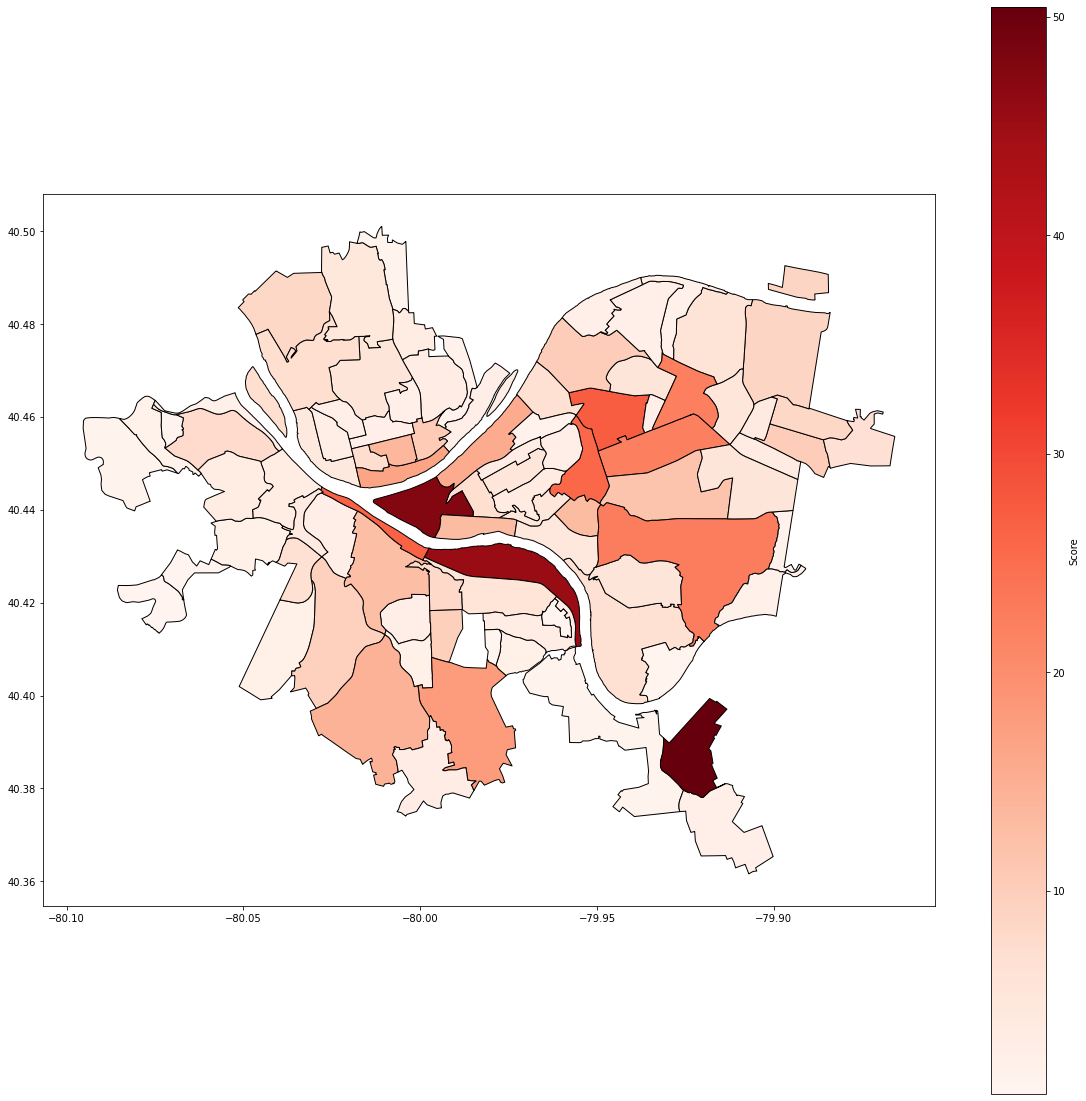

In [33]:
mergedMap = neighborhood.merge(merged_df, left_on='hood', right_on = "key_0") #Merge the neighborhood DataFrame with our merged DataFrame
#Plot them to generate a heat map
mergedMap.plot(column = "Overall Score", legend = True, cmap="Reds", edgecolor="black", legend_kwds = {"label" : "Score"}, figsize = (20,20))

On the map, we can see that Arlington Heights and Mt. Oliver are neighborhoods near each other, as are Oakwood and East Carnegie. Living in one of those areas, if not Mt. Oliver itself, would be the best neighborhood for a broke recent graduate to live in. 

# Conclusion


In merging all of our data, there is an obvious direct correlation between the amount of rented housing, crime rates, and parking meters. As the amount of housing for rent increases, generally so did the amount of crime and parking meters. This is likely due to a higher population living in those areas, meaning the city can make more money off of parking, and there are more people there to commit crimes or have crimes committed on them. While more rented housing is a good thing, more parking meters and crime is not, so in determining an overall best neighborhood, neither the neighborhood with the lowest amount of crime or the highest amount of housing was chosen (though the average price was also taken in to account for housing). The best neighborhood did have the lowest number of parking meters, but that was in part because there were many neighborhoods without any parking meters. 

   Housing did also play a more significant role in determining the best neighborhood, both because it is the biggest unavoidable expense of these and because if you can't find somewhere to live there, it can't be the best neighborhood to live in. Due to this, in our determination of the best neighborhood, we weighted the component score for housing higher than the other components. 
    
   For a broke recent college graduate, the best neighborhood in Pittsburgh is Mt. Oliver. Mt. Oliver ranked 19th from the worst for cheap housing—it did not do very well individually. However, combined with the lack of parking meters—there are 0 in Mt. Oliver—and the very low crime rate, it ended up being the best. It isn't the best neighborhood for any of our individual metrics, but it is the best result in the combination of them. 

## Reflections

## Safety
After looking at the data, I noticed how many neighborhoods there are with little to no crimes happening. Then again, these neighborhoods are almost all small (in size and population) as well as in the outskirts of the city, so it makes sense that there is little crime. I had been hoping to find that Shadyside was the best, as some of my favorite restaurants are there, and I like walking through there. Not suprisingly, the worst neighborhood (safety-wise) is the Southside Flats. I was also interested to see the crime surrounding Oakland, and realizing that it is pretty minimal provides me with security. The best neighborhood safety-wise is Mt. Oliver boro, however this is not a clear winner at all, and there are many, many other neighborhoods that are just as safe. However, Mt. Oliver is still a very clear winner with the least amount of crimes. Looking more into safety, I would like to find a way to correlate the rate of crime in a neighborhood to its population and size. I would also compare each neighborhood to similarly sized (both area and population) sections of the country as this would give good insight to crime compared to the US as a whole. 

## Housing
My personal favorite neighborhoods are closer to the center of Pittsburgh—I love Squirrel Hill and Shadyside, and those neighborhoods did rank pretty highly with housing alone. However, likely due to being more populated and towards the center of the city, there are higher crime rates and more parking meters. It makes sense to me that a neighborhood more towards the outskirts of the city won because of that though: there less housing, but it being cheaper with less crime and parking fees probably outweighed that. If I can afford it though, because it does trend towards the more expensive end, I will personally still choose Shadyside or Squirrel Hill over Mt. Oliver. I do think it would be worth considering transportation time and costs into determining where to live, and that would probably be the next metric I would consider if I were to add on to this project, as that is another high cost in an adult's day-to-day life. Given that Mt. Oliver won and is a neighborhood more on the outskirts of the city, I could see factoring in transportation to be a gamechanger. 

## Parking

After looking at the data, it is visible how some neighborhoods have significantly fewer parking meters than others. Some neighborhoods even have no parking meters at all. However, the neighborhoods without parking meters are most likely within industrial areas that would not have public parking or are in neighborhoods comprised solely of houses. It is visible within the map that areas such as cities have higher densities of parking meters, making those less viable options for living in if on a budget. Cities would also be more expensive in terms of rent to live in, and have higher crime rates. Combining the data that I gathered with the rest of my group's information, I was able to see that Mt. Oliver had no parking meters, relatively reasonable pricing on homes, and is a low crime rate areas. While Mt. Oliver is not directly next to the city, which may be a negative to a recent college graduate, it is still a great option for someone who wants a nice, safe place to live if you are on a budget and want to park your car without paying meter rates.